# Product Design Mining - as a Product Designer, I want to know users' preferences - specifically paint points - , so that I can improve the product

### False positives are more costly, in that they miss critical negative pain points and feedback by seeing them as positive - this informs metric of F 0.5 on Positive class of sentiment being the focus

### False negatives on Negative class are the focus as they miss out on actual negative feedbacks, informing a metric of F2 on Negative class of sentiment

## Business value: Allows for improving the product and bring in new customers/remedy possible churn of customers from the platform or brand loyalty

# Imports and reading in data

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Import the displaCy library
from spacy import displacy

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [3]:
plt.style.use('seaborn-talk')

## Reading in data

In [4]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

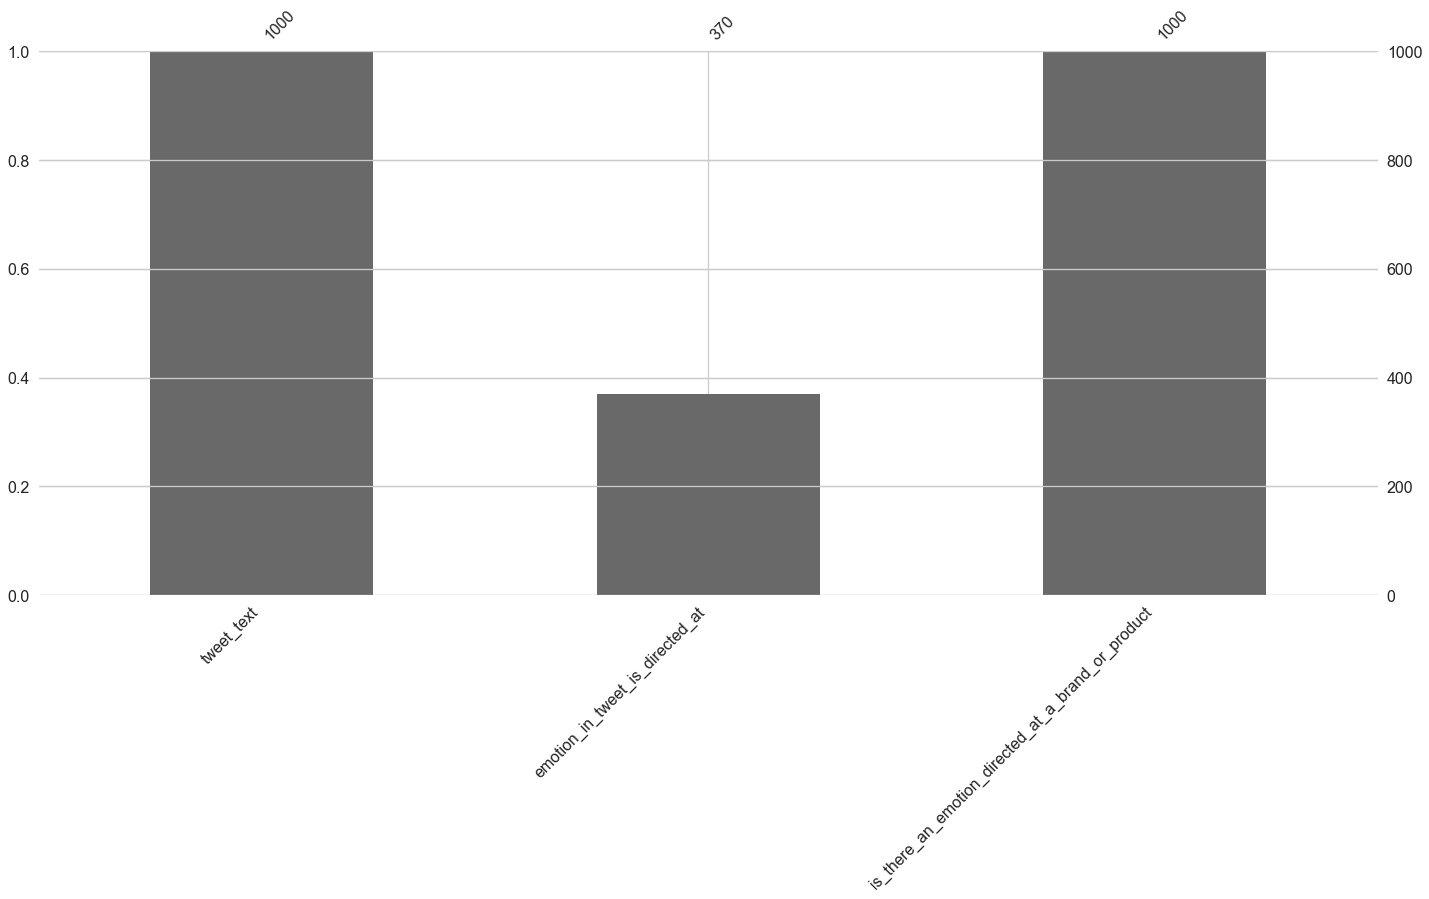

In [6]:
msno.bar(df.sample(1000))

In [7]:
df.dropna(subset=['emotion_in_tweet_is_directed_at'],inplace=True)

df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [8]:
df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# print(5801 / len(df))

In [10]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != 'No emotion toward brand or product']
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

Positive emotion    2672
Negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

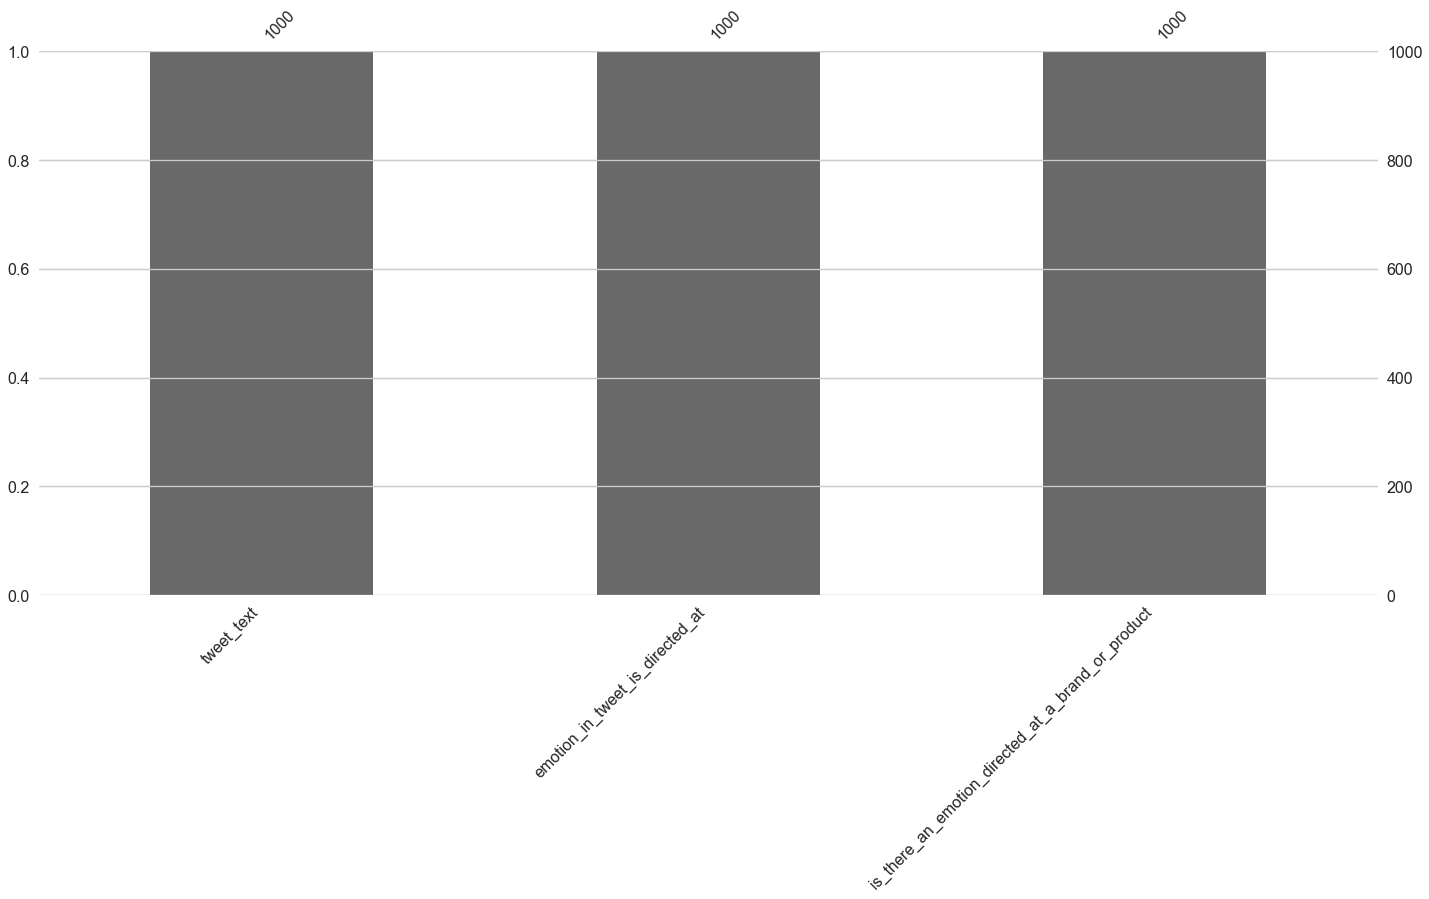

In [12]:
msno.bar(df.sample(1000))

# Preprocessing

## Renaming columns

In [13]:
df = df.rename(columns={"tweet_text": "text", "emotion_in_tweet_is_directed_at":"direction", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})

df

text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9077  @mention your PR guy just convinced me to swit...   
9079  &quot;papyrus...sort of like the ipad&quot; - ...   
9080  Diller says Google TV &quot;might be run over ...   
9085  I've always used Camera+ for my iPhone b/c it ...   
9088                      Ipad everywhere. #SXSW {link}   

                            direction         sentiment  
0                              iPhone  Negative emotion  
1                  iPad or iPhone App  Positive emotion  
2                                iPad  Positive emotion  
3                  iPad or iPhone App  Negative emotion  
4                              Google  Positive emotion  
...                               ...               ...  
9077                           iPhone  Positive emotion  
9079                             iPad  Positive emotion  
9080  Other Google product or service  Negative emotion  
9085               iPad or iPhone App  Positive emotion  
9088                             iPad  Positive emotion  

[3191 rows x 3 columns]

In [14]:
df.sentiment.value_counts(dropna=False)

Positive emotion    2672
Negative emotion     519
Name: sentiment, dtype: int64

In [15]:
df.direction.value_counts(dropna=False)

iPad                               918
Apple                              638
iPad or iPhone App                 460
Google                             414
iPhone                             287
Other Google product or service    283
Android App                         80
Android                             77
Other Apple product or service      34
Name: direction, dtype: int64

## Mapping sentiment to 0 for negative, 1 for positive

In [16]:
df.sentiment = df.sentiment.map({'Positive emotion': 1, 'Negative emotion': 0})

In [17]:
df.sentiment.value_counts(dropna=False)

1    2672
0     519
Name: sentiment, dtype: int64

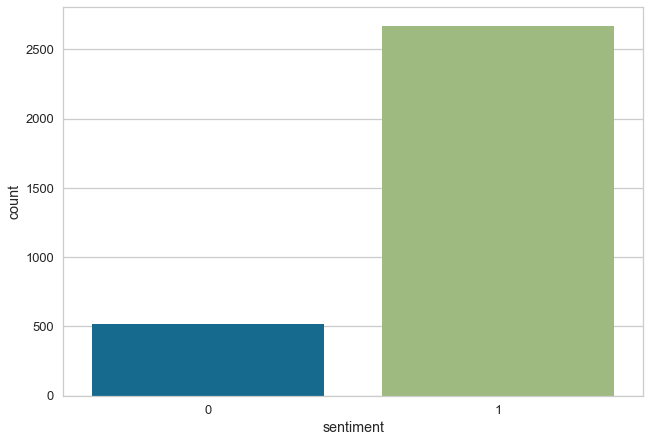

In [18]:
sns.countplot(df.sentiment)

In [19]:
df.direction.value_counts(dropna=False)

iPad                               918
Apple                              638
iPad or iPhone App                 460
Google                             414
iPhone                             287
Other Google product or service    283
Android App                         80
Android                             77
Other Apple product or service      34
Name: direction, dtype: int64

## Mapping direction of the tweet to 0 for apple and its products/services, 1 for google, 2 for unknown

In [20]:
df.direction = df.direction.map({'iPad':0, 'Apple':0,'iPad or iPhone App':0,'iPhone':0,'Other Apple product or service':0,'Google':1,'Other Google product or service':1,'Android App':1,'Android':1})

In [21]:
df.direction.value_counts(dropna=False)

0    2337
1     854
Name: direction, dtype: int64

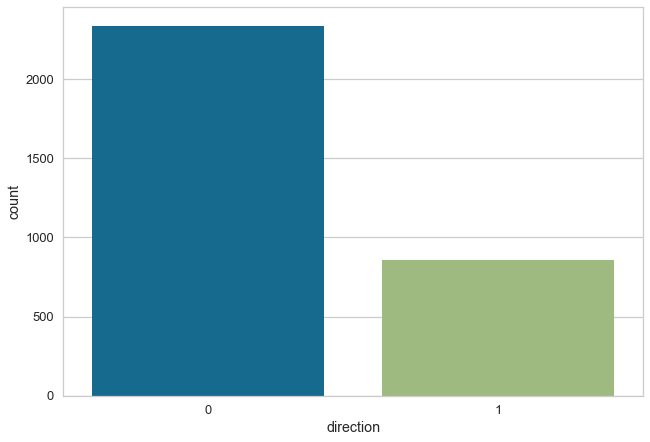

In [22]:
sns.countplot(df.direction)

In [23]:
# #Wherein 1 in sentiment is not having a strong emotion/can't tell, and 2 in direction is a NaN that's been filled 
# neutrals = [1,2]
# df[(df[['sentiment','direction']].values == neutrals).all(axis=1)]

In [24]:
# len(df)

In [25]:
# df.sentiment.value_counts(dropna=False)

In [26]:
# df.direction.value_counts(dropna=False)

In [27]:
# df.query('@neutrals[0] != sentiment and @neutrals[1] == direction').shape[0]

## Shows that the NaNs of direction were entered as a neutral sentiment

In [28]:
# 5801 - 357

# General text preprocessing function

In [29]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrussort of like the ipad&quot;  nice...
9080    Diller says Google TV &quot;might be run over ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                           Ipad everywhere #SXSW link
Name: text, Length: 3191, dtype: object

# Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, and exclamation/question marks

In [30]:
def tweet_special_count(string, character):
    '''docstring'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [31]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()



text  direction  sentiment  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0          0   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          0          1   
2  @swonderlin Can not wait for #iPad 2 also They...          0          1   
3  @sxsw I hope this year's festival isn't as cra...          0          0   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          1          1   

   tweet_len  tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0        122           23         2            1              1             1   
1        137           22         1            2              1             1   
2         77           15         2            1              1             0   
3         81           15         1            1              0             0   
4        125           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.411765                 17           100.000000

In [32]:
clean_df.columns

Index(['text', 'direction', 'sentiment', 'tweet_len', 'tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words', 'excl_q_marks',
       'mean_word_len', 'count_unique_word', 'word_unique_percent'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [33]:
from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 475),
 ('iPhone', 345),
 ('SXSW', 234),
 ('Google', 229),
 ('2', 203),
 ('Austin', 200),
 ('#sxsw #', 88),
 ('Android', 83),
 ('#sxsw', 79),
 ('#SXSW #', 72),
 ('sxsw', 71),
 ('today', 66),
 ('iPad2', 52),
 ('RT @mention', 50),
 ('one', 41),
 ('SxSW', 41),
 ('Today', 37),
 ('3', 34),
 ('Circles', 30),
 ('iPad 2', 29)]

### Most Common Tokens W/Entities

In [34]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

### Most Common Products

In [35]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

## Analysis of numerical features- TBD: Writeup
### Distributions

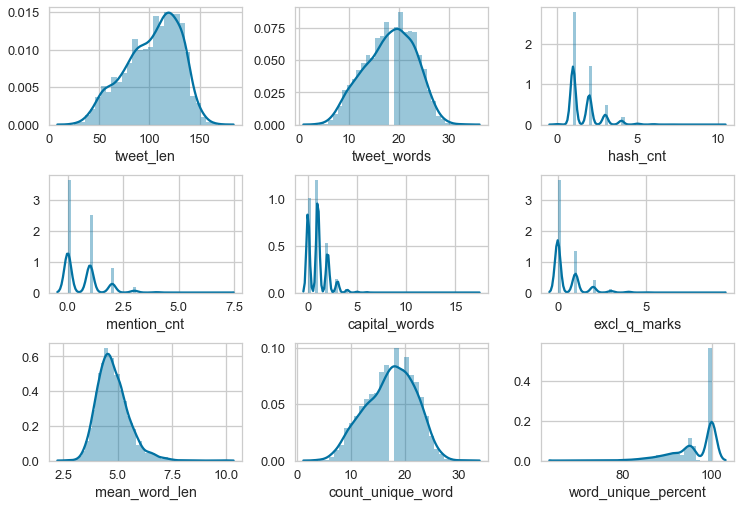

In [36]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity

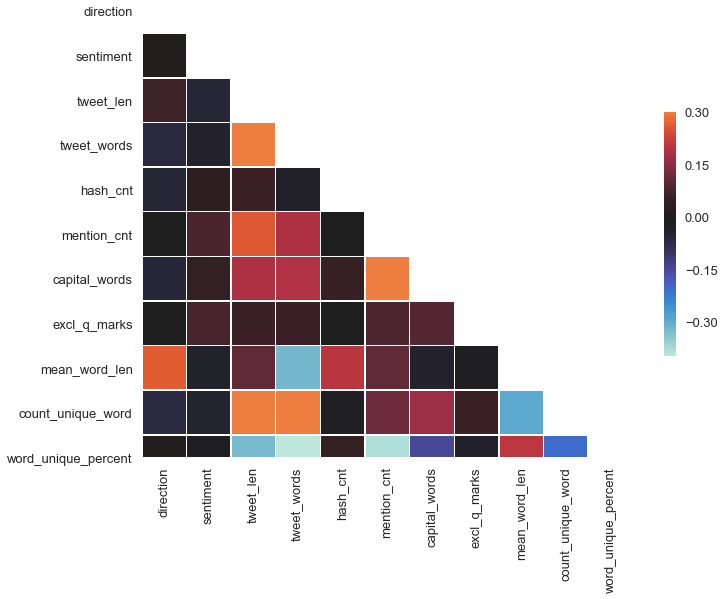

In [37]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Pairplot

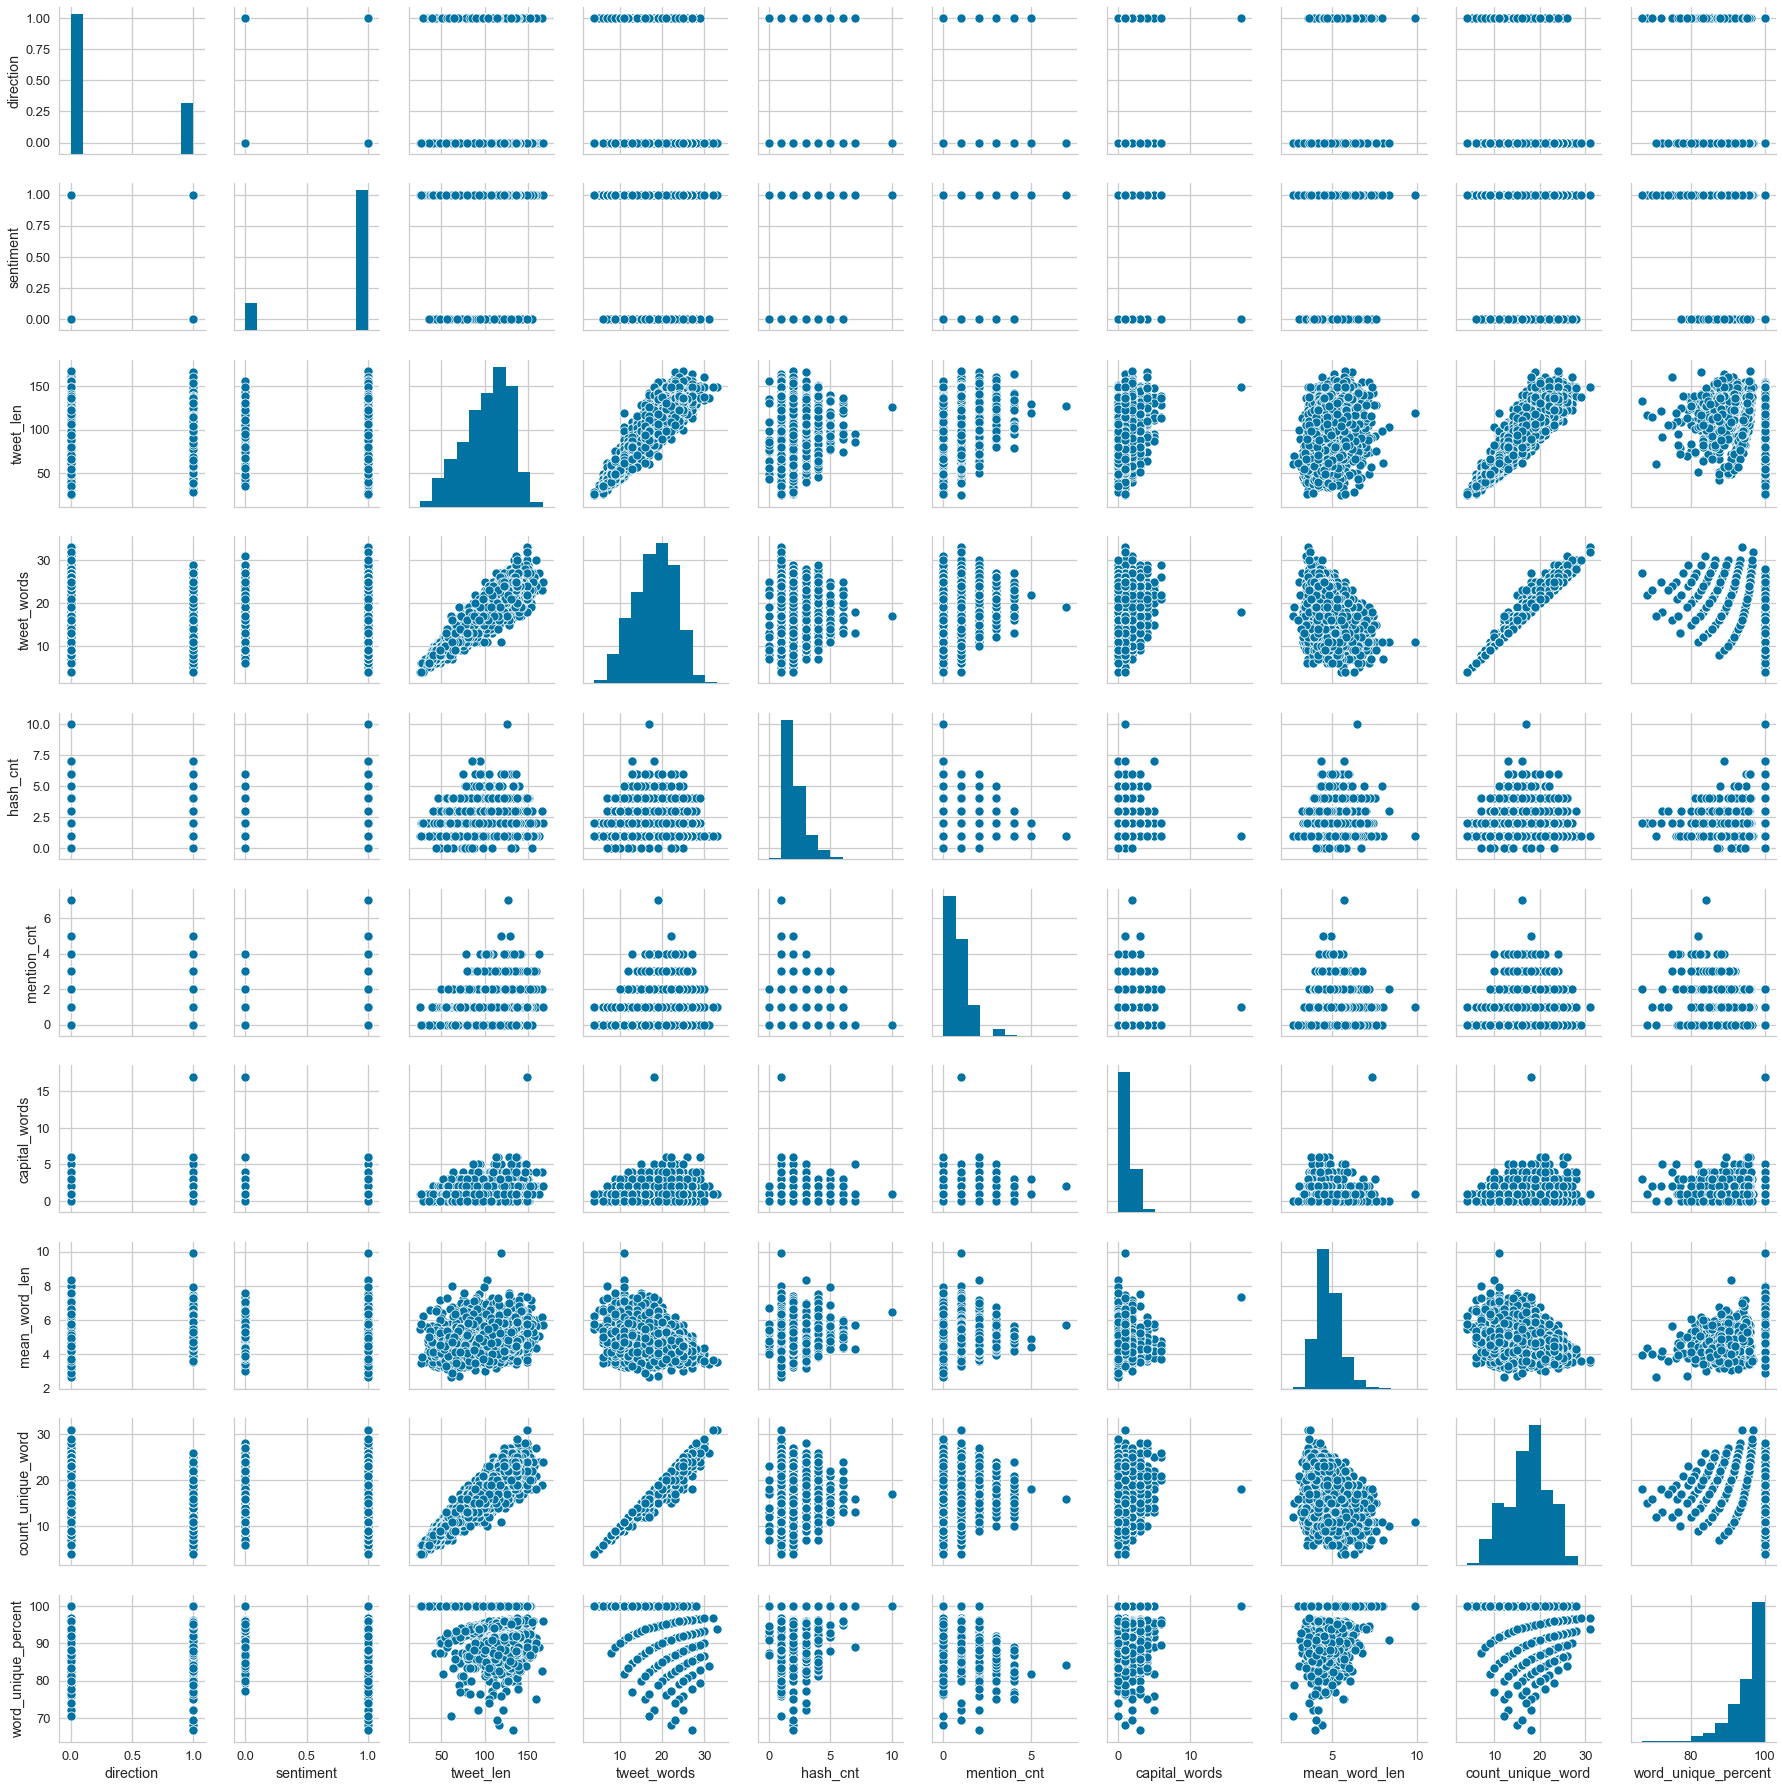

In [38]:
sns.pairplot(clean_df[['direction', 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words','mean_word_len', 'count_unique_word', 'word_unique_percent']])

#### Dropping tweet_len due to high correlation with tweet_words

In [39]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

text  direction  sentiment  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0          0   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          0          1   
2  @swonderlin Can not wait for #iPad 2 also They...          0          1   
3  @sxsw I hope this year's festival isn't as cra...          0          0   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          1          1   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           23         2            1              1             1   
1           22         1            2              1             1   
2           15         2            1              1             0   
3           15         1            1              0             0   
4           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.411765                 17           100.000000

# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [40]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrussort of like the ipad&quot;  nice...
9080    Diller says Google TV &quot;might be run over ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                           Ipad everywhere #SXSW link
Name: text, Length: 3191, dtype: object

In [41]:
from wordcloud import WordCloud

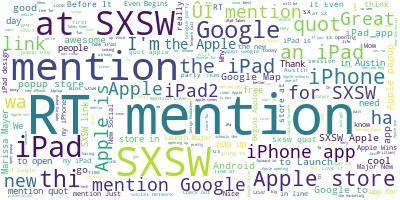

In [42]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [43]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrussort of like the ipad&quot; nice!...
9080    Diller say Google TV &quot;might be run over b...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                           Ipad everywhere #SXSW link
Name: text, Length: 3191, dtype: object

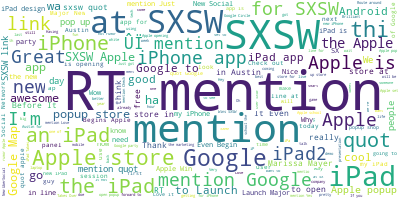

In [44]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [45]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9077    @mention PR guy convinced switch back iPhone G...
9079    &quot;papyrussort like ipad&quot; nice! Lol! #...
9080    Diller say Google TV &quot;might run PlayStati...
9085    I've always used Camera+ iPhone b/c ha image s...
9088                           Ipad everywhere #SXSW link
Name: text, Length: 3191, dtype: object

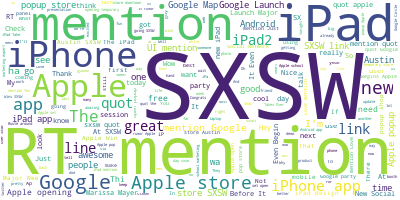

In [47]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

# Features after cleaning and analysis

In [48]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()

text  direction  sentiment  \
0  @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0          0   
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          0          1   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          0          1   
3  @sxsw I hope year's festival crashy year's iPh...          0          0   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          1          1   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           17         2            1              1             1   
1           16         1            2              1             1   
2            9         2            1              1             0   
3           10         1            1              0             0   
4           16         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  tweet_len  
0       4.882353                 16            94.117647         99  
1       5.812500                 16           100.000000        108  
2       4.555556                  9           100.000000         49  
3       5.000000                  9            90.000000         59  
4       6.687500                 16           100.000000        122

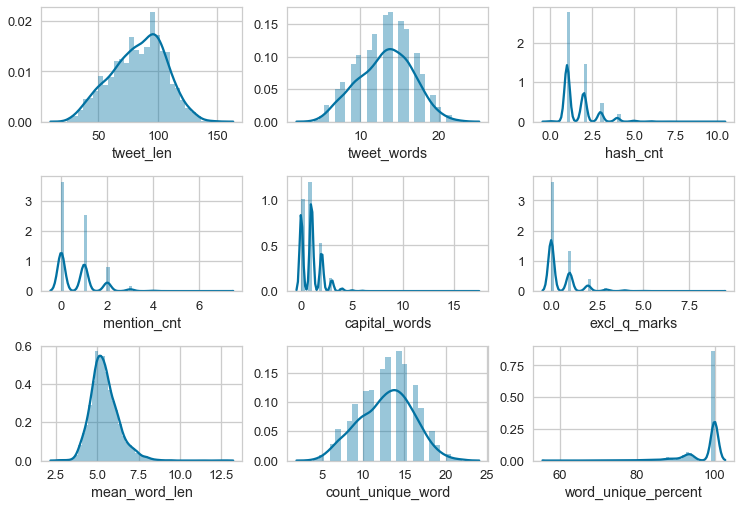

In [49]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

In [50]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued

## t-SNE of k-means clusters, overall document, text vs. classes

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



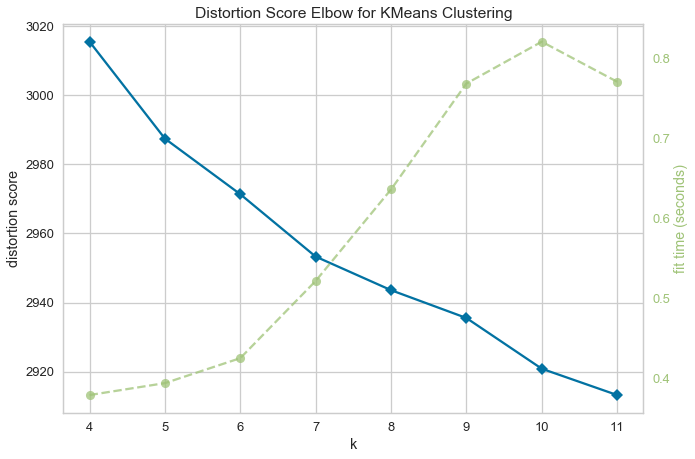

In [51]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [52]:
from yellowbrick.text import TSNEVisualizer
X = tfidf.fit_transform(clean_df['text'])


In [53]:
clusters = KMeans(n_clusters=7)
clusters.fit(X)


KMeans(n_clusters=7)

W0625 19:53:58.674504 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0625 19:53:58.691825 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0625 19:53:58.706153 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0625 1

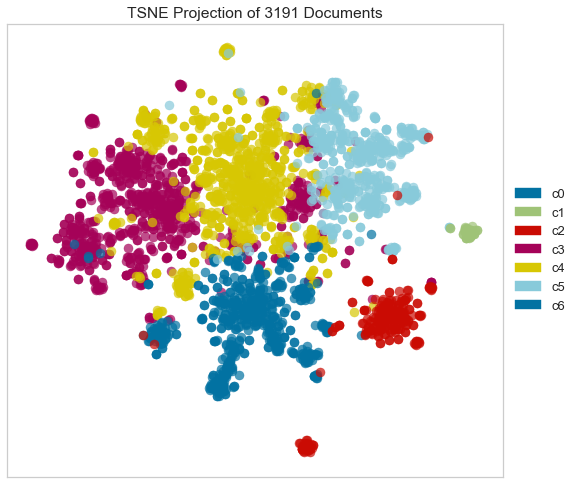

0 : network, social, circles, called, major, launch, new, possibly, google, today
1 : before, begins, even, wins, it, apple, link, mention, sxsw, via
2 : quot, mention, rt, sxsw, heard, apple, conferences, technology, come, ever
3 : iphone, mention, app, sxsw, android, link, rt, new, apple, free
4 : ipad, mention, sxsw, link, rt, app, new, the, win, design
5 : apple, store, popup, link, sxsw, austin, mention, ipad2, temporary, opening
6 : google, sxsw, mention, link, party, rt, mobile, map, mayer, marissa


In [54]:
tsne = TSNEVisualizer(size=(800, 600))
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])

tsne.show()
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))
    


### TSNE of tweet text

W0625 19:54:09.601776 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


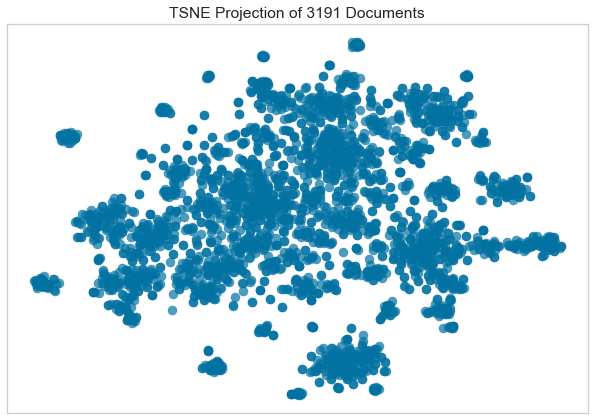

In [55]:
tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment

W0625 19:54:20.432447 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0625 19:54:20.468936 4680740288 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


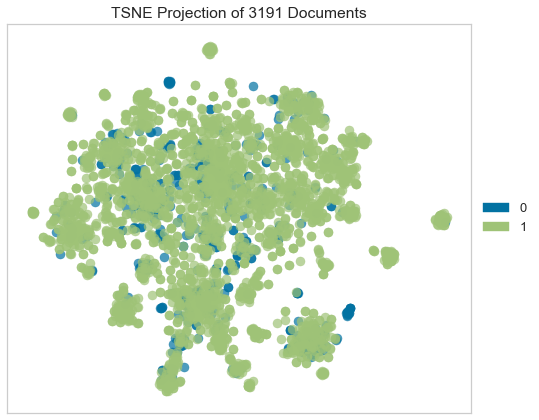

In [56]:
y = clean_df['sentiment']
tsne = TSNEVisualizer()
tsne.fit(X,y)
tsne.show()

### Word modeling t-SNE

In [57]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [58]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [59]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['Google']

W0625 19:54:20.815287 4680740288 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


array([-0.03941615,  0.09349434,  0.06122613, -0.02561923,  0.04535696,
        0.02910458,  0.0029482 , -0.05689222,  0.09167798,  0.00169091,
        0.01426283, -0.04761216,  0.04288805,  0.0456051 ,  0.0109291 ,
        0.02059372, -0.0207371 ,  0.09017048,  0.02013262,  0.0125602 ,
       -0.09755713,  0.03458619,  0.06463128,  0.07608189, -0.0170926 ,
       -0.03836137, -0.01851941,  0.01053825, -0.01125785, -0.02250434,
        0.01360306, -0.00157677, -0.02279938,  0.00321139, -0.0016816 ,
        0.0237857 ,  0.00976299, -0.00986882, -0.00678393,  0.02365813,
        0.073258  ,  0.04756916,  0.0688476 , -0.00150118,  0.0197656 ,
       -0.00596545,  0.03114297, -0.00093933, -0.02339317, -0.02699571,
        0.02060679,  0.03864352,  0.04048691, -0.07010596,  0.0139701 ,
       -0.00465422, -0.00745242,  0.0787956 , -0.1001322 , -0.01467579,
       -0.0503416 , -0.0215532 , -0.07600695,  0.0699995 , -0.03841516,
       -0.00428027, -0.09770261,  0.0085747 , -0.0082233 , -0.05

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



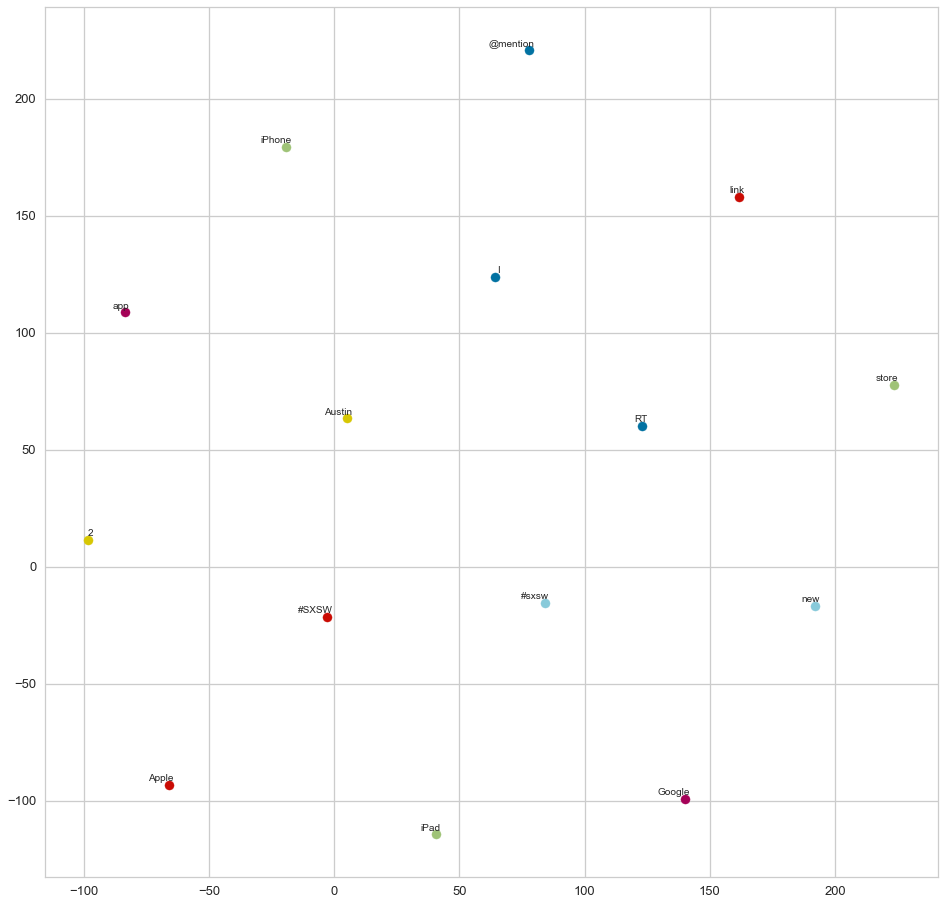

In [60]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

In [61]:
google_similar = model.most_similar('Google')

google_similar

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('@mention', 0.9972066879272461),
 ('iPad', 0.9972043037414551),
 ('RT', 0.9970294237136841),
 ('#SXSW', 0.9968732595443726),
 ('link', 0.9967180490493774),
 ('Apple', 0.9966216683387756),
 ('iPhone', 0.9965415000915527),
 ('2', 0.9964315295219421),
 ('I', 0.9963968992233276),
 ('store', 0.9963245391845703)]

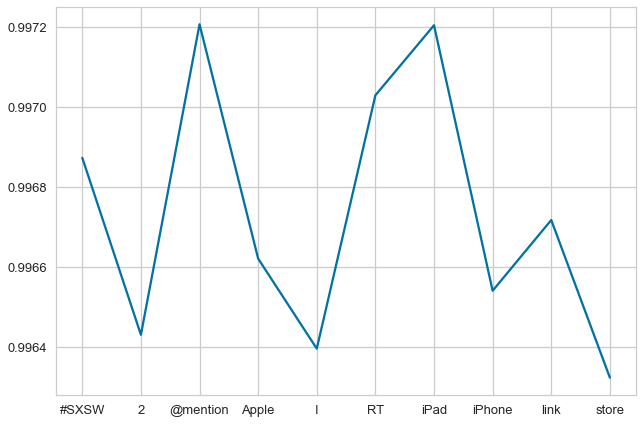

In [62]:
sns.lineplot(*zip(*google_similar))

In [63]:
apple_similar = model.most_similar('Apple')

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



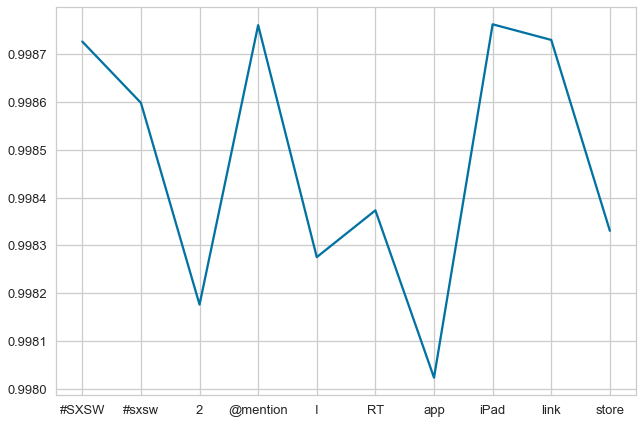

In [64]:
sns.lineplot(*zip(*apple_similar))

# Bigrams and N-grams

In [65]:
from nltk import bigrams

In [66]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9077    [@mention, PR, guy, convinced, switch, back, i...
9079    [", papyrussort, like, ipad, ", nice, !, Lol, ...
9080    [Diller, say, Google, TV, ", might, run, PlayS...
9085    [I've, always, used, Camera, +, iPhone, b, /, ...
9088                      [Ipad, everywhere, #SXSW, link]
Name: tokens, Length: 3191, dtype: object

In [67]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:11]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [68]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

In [69]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 922),
 (('iPad', '2'), 457),
 (('#SXSW', 'link'), 155),
 (('!', '!'), 147),
 (('@mention', '#sxsw'), 135),
 (('@mention', '@mention'), 132),
 (('link', '#sxsw'), 119),
 (('via', '@mention'), 106),
 (('!', 'RT'), 104),
 (('!', 'link'), 101),
 (('iPhone', 'app'), 99),
 (('popup', 'store'), 95),
 (('!', '#sxsw'), 94),
 (('w', '/'), 86),
 (('@mention', 'Google'), 83),
 (('Apple', 'Store'), 80),
 (('#sxsw', 'link'), 79),
 (('@mention', 'Apple'), 77),
 (('Apple', 'store'), 76),
 (('!', '#SXSW'), 69)]

In [70]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0         (RT, @mention)    922
1              (iPad, 2)    457
2          (#SXSW, link)    155
3                 (!, !)    147
4      (@mention, #sxsw)    135
5   (@mention, @mention)    132
6          (link, #sxsw)    119
7        (via, @mention)    106
8                (!, RT)    104
9              (!, link)    101
10         (iPhone, app)     99
11        (popup, store)     95
12            (!, #sxsw)     94
13                (w, /)     86
14    (@mention, Google)     83
15        (Apple, Store)     80
16         (#sxsw, link)     79
17     (@mention, Apple)     77
18        (Apple, store)     76
19            (!, #SXSW)     69

## Plot of top 20 bigrams

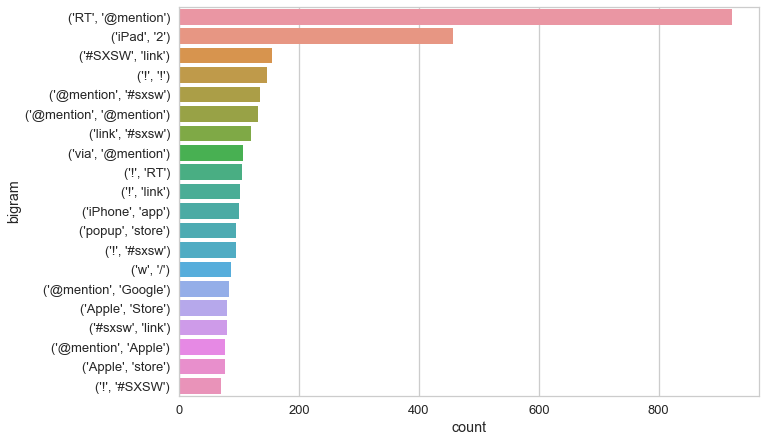

In [71]:
sns.barplot(data=bigram_df, x="count", y="bigram")

## Network plot of bigrams

In [72]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

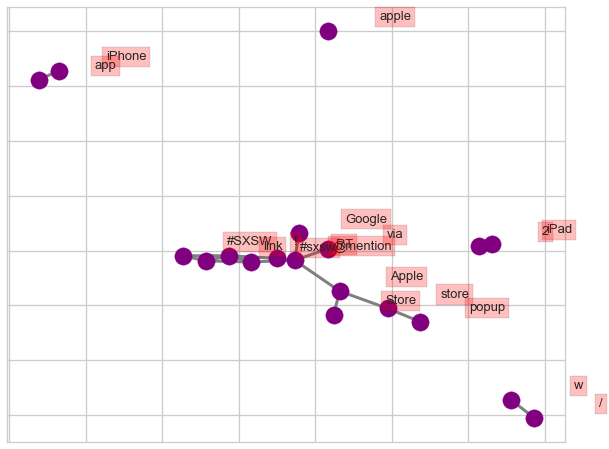

In [73]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

# TBD: LDA visualization

# Modeling

## TBD: Multiple classifiers, tuning, better display of metrics, feature impact/analysis of models

In [74]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Making a scorer for grid searching out of cohen's kappa and a function for selective f-scores

In [75]:
from sklearn.metrics import cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score)

## DataFrameMapper with Tf-idf Vectorization

In [76]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('direction', None),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None),
    ('mean_word_len',None),
    ('count_unique_word',None),
    ('word_unique_percent',None)
 ])

In [77]:
X = mapper.fit_transform(clean_df)

In [78]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   6.53846154,
         13.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   5.16666667,
         18.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   5.75      ,
          4.        , 100.        ]])

In [79]:
clean_df.direction.value_counts(dropna=False)

0    2337
1     854
Name: direction, dtype: int64

## Train test splits

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

# TBD: Comparison of scaler effects - both decreased performance greatly

## Minmax Scaling

In [81]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

## Standard scaling

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sts = scaler.fit_transform(X_train)
X_test_sts = scaler.transform(X_test)

## PCA train_test split- TBD if/how using

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = X
pca.fit(X_pca)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=42,stratify=y)

## Comparing class balance 

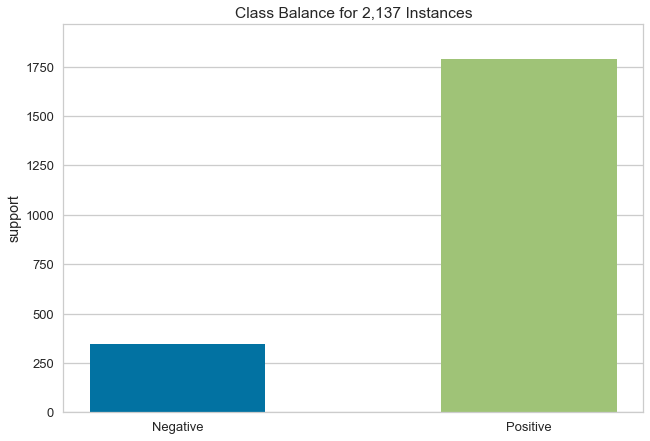

In [84]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Positive"])

visualizer.fit(y_train)
visualizer.show()

# SVC Base Model for Comparison

In [89]:
from sklearn.svm import SVC
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.84      1.00      0.91       883

    accuracy                           0.84      1054
   macro avg       0.42      0.50      0.46      1054
weighted avg       0.70      0.84      0.76      1054



In [99]:
from sklearn.metrics import fbeta_score

def fscores(y_test=y_test, y_pred=y_pred):
    f05 = fbeta_score(y_test, y_pred, average=None, beta=0.5, labels=[0,1])
    f2 = fbeta_score(y_test, y_pred, average=None, beta=2.0, labels=[0,1])
    for idx,c in enumerate(f05):
        print (f'F0.5 of {idx} class is {f05[idx]}')
        print (f'F2 of {idx} class is {f2[idx]}')
        print ('-----------')


In [91]:
svc_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.0


In [92]:
fscores()

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.8658560502059226
F2 of 1 class is 0.962712603576101
-----------
F0.5 of 2 class is 0.0
F2 of 2 class is 0.0
-----------


## Balanced SVC

In [96]:
from sklearn.svm import SVC
clf = SVC(class_weight="balanced", random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.18      0.79      0.30       171
           1       0.88      0.31      0.46       883

    accuracy                           0.39      1054
   macro avg       0.53      0.55      0.38      1054
weighted avg       0.77      0.39      0.43      1054



In [97]:
svc_bal_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.0


In [100]:
fscores()

F0.5 of 0 class is 0.2144899904671115
F2 of 0 class is 0.4726890756302521
-----------
F0.5 of 1 class is 0.6453132359868112
F2 of 1 class is 0.3565851119208746
-----------


# Tuning SVC

In [101]:
from sklearn.svm import SVC

In [104]:
from sklearn.model_selection import GridSearchCV

In [105]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

In [106]:
grid = GridSearchCV(SVC(class_weight="balanced", random_state=0),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 27.5min finished


GridSearchCV(estimator=SVC(class_weight='balanced', random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [107]:
print(grid.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=0.001, kernel='poly', random_state=0)


In [108]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.66      0.51      0.58       171
           1       0.91      0.95      0.93       883

    accuracy                           0.88      1054
   macro avg       0.79      0.73      0.75      1054
weighted avg       0.87      0.88      0.87      1054



In [109]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.5067311137598445


# Undersampling techniques

In [110]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [111]:
from imblearn.under_sampling import NearMiss # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y))
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 2672, 0: 519})
Resampled dataset shape Counter({0: 348, 1: 348})


In [112]:
model = SVC(class_weight="balanced", random_state=0)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.13      0.23      0.17       171
           1       0.82      0.70      0.76       883

    accuracy                           0.63      1054
   macro avg       0.48      0.47      0.46      1054
weighted avg       0.71      0.63      0.66      1054



In [113]:
bal_nm_cohen = cohen_kappa_score(y_test,y_pred)
print(bal_nm_cohen)

-0.05254140201649493


## Grid search on undersampling

In [114]:
grid.fit(X_res,y_res)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.3min finished


GridSearchCV(estimator=SVC(class_weight='balanced', random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [115]:
print(grid.best_estimator_)

SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', random_state=0)


In [116]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.20      0.74      0.32       171
           1       0.90      0.44      0.59       883

    accuracy                           0.49      1054
   macro avg       0.55      0.59      0.46      1054
weighted avg       0.78      0.49      0.55      1054



In [119]:
grid_nm_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_nm_cohen)

0.08746795646916572


# Other undersampling techniques

In [120]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 348), (1, 1521)]


In [121]:
model = SVC(class_weight="balanced", random_state=0)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.47      0.28       171
           1       0.86      0.63      0.73       883

    accuracy                           0.60      1054
   macro avg       0.53      0.55      0.50      1054
weighted avg       0.75      0.60      0.65      1054



In [123]:
bal_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)
print(bal_ncr_cohen)

0.08746795646916572


## Tuned SVC on NCR

In [124]:
grid.fit(X_resampled,y_resampled)
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 25.6min finished


              precision    recall  f1-score   support

           0       0.62      0.54      0.58       171
           1       0.91      0.94      0.92       883

    accuracy                           0.87      1054
   macro avg       0.77      0.74      0.75      1054
weighted avg       0.87      0.87      0.87      1054



In [125]:
tune_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)

In [126]:
print(tune_ncr_cohen)

0.5042747549070842


# TBD: Conclusions - best model results and interpretation, business recommendations, future work

# Future work: Outlier detection approaches, multilabel classification